In [1]:
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/envs/graphcnn/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
d = 50    
n = 1000

X1 = np.random.normal(0, 1, (n, d)).astype(np.float32)
X2 = np.random.normal(0, 1, (n, d)).astype(np.float32)
X = np.stack([X1, X2], axis=-1)

w1 = np.random.uniform(-1, 1, d)
w2 = np.random.uniform(-1, 1, d)

t1 = X1.dot(w1) + np.random.normal(0, .1, n)
t2 = X2.dot(w2) + np.random.normal(0, .1, n)
t = np.tanh(t1 + t2)

y = np.ones(t.shape, dtype=np.uint8)
y[t > t.mean() + 0.4 * t.std()] = 0

In [3]:
n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

In [4]:
print(X_train.shape)

(500, 50, 2)


In [5]:
from scipy import sparse

In [6]:
adj_matrix = np.genfromtxt('/Users/linggeli/cnn_graph/fmri/adj_matrix.csv', delimiter=',')
print(adj_matrix.shape)

(375, 375)


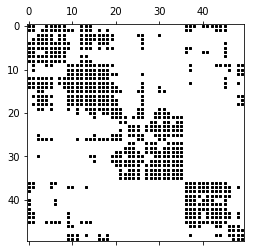

In [7]:
A = adj_matrix[50:100, 50:100]
A[A < 0.8] = 0
A = sparse.csr_matrix(A).astype(np.float32)
plt.spy(A, markersize=2, color='black');

In [8]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

Layer 0: M_0 = |V| = 56 nodes (6 added),|E| = 347 edges
Layer 1: M_1 = |V| = 28 nodes (2 added),|E| = 140 edges
Layer 2: M_2 = |V| = 14 nodes (1 added),|E| = 42 edges
Layer 3: M_3 = |V| = 7 nodes (0 added),|E| = 12 edges


In [9]:
X_train1 = coarsening.perm_data(X_train[:, :, 0], perm)
X_val1 = coarsening.perm_data(X_val[:, :, 0], perm)
X_test1 = coarsening.perm_data(X_test[:, :, 0], perm)

X_train2 = coarsening.perm_data(X_train[:, :, 1], perm)
X_val2 = coarsening.perm_data(X_val[:, :, 1], perm)
X_test2 = coarsening.perm_data(X_test[:, :, 1], perm)

X_train = np.stack([X_train1, X_train2], axis=-1)
X_val = np.stack([X_val1, X_val2], axis=-1)
X_test = np.stack([X_test1, X_test2], axis=-1)

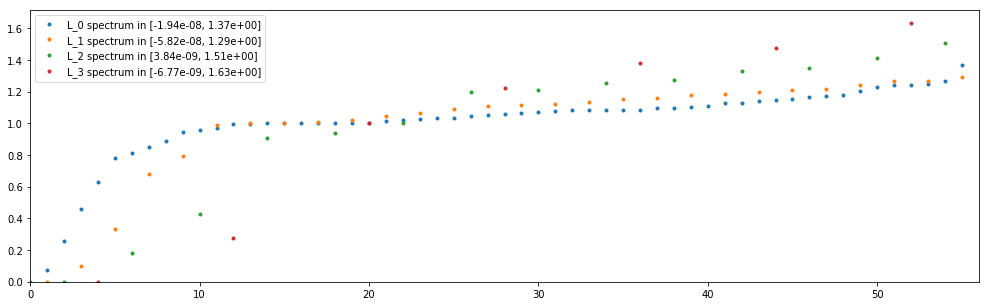

In [10]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [11]:
L

[<56x56 sparse matrix of type '<class 'numpy.float32'>'
 	with 750 stored elements in Compressed Sparse Row format>,
 <28x28 sparse matrix of type '<class 'numpy.float32'>'
 	with 308 stored elements in Compressed Sparse Row format>,
 <14x14 sparse matrix of type '<class 'numpy.float32'>'
 	with 98 stored elements in Compressed Sparse Row format>,
 <7x7 sparse matrix of type '<class 'numpy.float32'>'
 	with 31 stored elements in Compressed Sparse Row format>]

In [12]:
from lib.models import *

In [13]:
from fmri.graph_models import multi_cgcnn

In [14]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 10
params['batch_size']     = 10
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

params['n_graph'] = 2

In [15]:
model = multi_cgcnn(L, **params)

NN architecture
  input: M_0 = 56
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 56 * 32 / 4 = 448
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 14 * 64 / 2 = 448
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 448 * 512 = 229376
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2


In [16]:
import tensorflow as tf

In [17]:
data_tf = tf.convert_to_tensor(X_test[:10], np.float32)

In [18]:
data_tf

<tf.Tensor 'Const:0' shape=(10, 56, 2) dtype=float32>

In [19]:
model.inference(data_tf, 1.0)

<tf.Tensor 'add:0' shape=(10, 2) dtype=float32>

In [20]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

step 200 / 500 (epoch 4.00 / 10):
  learning_rate = 8.57e-04, loss_average = 1.46e+00
  validation accuracy: 61.00 (61 / 100), f1 (weighted): 59.03, loss: 1.53e+00
  time: 12s (wall 5s)
step 400 / 500 (epoch 8.00 / 10):
  learning_rate = 6.98e-04, loss_average = 1.40e+00
  validation accuracy: 64.00 (64 / 100), f1 (weighted): 61.98, loss: 1.52e+00
  time: 24s (wall 10s)
step 500 / 500 (epoch 10.00 / 10):
  learning_rate = 6.30e-04, loss_average = 1.35e+00
  validation accuracy: 70.00 (70 / 100), f1 (weighted): 70.00, loss: 1.47e+00
  time: 30s (wall 12s)
validation accuracy: peak = 70.00, mean = 65.00
